In [1]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Sigmoid, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
#         if forwards:
#             b_minus  = self.b_backward(self.theta_b, Xt)
#             b_plus = self.b_forward(theta, Xt)
#             delta_Xt = b_plus - W
#         else:
#             b_minus  = self.b_backward(theta, Xt)
#             b_plus = self.b_forward(self.theta_f, Xt)
            
#             delta_Xt = (b_minus + W)[:,]

In [51]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
    
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
#     @partial(jit, static_argnums=(0,3))
    def loss_for_trajectory(self, Xt, theta, W, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        if forwards:
            b_minus  = self.b_backward(self.theta_b, Xt)
            b_plus = self.b_forward(theta, Xt)
        else:
            b_minus  = self.b_backward(theta, Xt)
            b_plus = self.b_forward(self.theta_f, Xt)

            
        delta_Xt = Xt[:, 1:, :] - Xt[:, :-1, :]  
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, :-1,:] - b_minus[:, 1:,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * self.dt 
        
        out =  ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
        if np.isnan(out).any() or np.isinf(out).any():
            import pdb; pdb.set_trace()
        return out

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, theta, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward if forwards else (lambda X, theta: -self.b_backward(X, theta))
        )
        
        t, Xt, *W = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, X0=batch,
            N= self.number_time_steps, theta=theta
        )
        
#         cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = self.loss_for_trajectory(Xt, theta, W, forwards)

        J = np.mean(main_term  )
        J = np.squeeze(J)
        return J
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            theta, batch,
            batch_terminal_empirical, H ,  forwards
        )

#     @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        for i in tqdm(range(IPFP_iterations)):

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params_b = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params_b, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.theta_b = params_b

            itercount = itertools.count()

            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, batch_f, True
                    )
                params_f = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params_f, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.theta_f = params_f

            self.loss_f = loss_f
            self.loss_b = loss_b

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

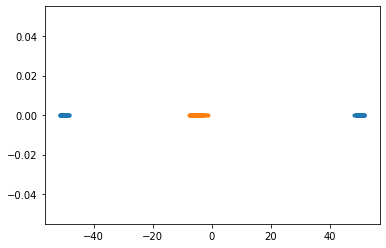

In [63]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 50
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) - 50
X2 = np.concatenate((X21, X22), axis=0)

# X1 , X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [64]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=500 , step_size = 0.001, weights=[200])

loss b 0.4662927985191345
loss f -0.027223700657486916
loss b 0.06017879769206047
loss f -0.026624586433172226
loss b 0.16291123628616333
loss f -0.016405487433075905
loss b 0.22330613434314728
loss f -0.0049937511794269085
loss b 0.14297951757907867
loss f 0.012493424117565155
loss b 0.19086232781410217
loss f 0.030303001403808594
loss b 0.23462650179862976
loss f 0.04891597852110863
loss b 0.2902469336986542
loss f 0.06848293542861938
loss b 0.3392075300216675
loss f 0.09525533020496368
loss b 0.2641785144805908
loss f 0.11516840010881424
loss b 0.39428454637527466
loss f 0.14522548019886017
loss b 0.5570376515388489
loss f 0.16930903494358063
loss b 0.317632257938385
loss f 0.20445939898490906
loss b 0.19127364456653595
loss f 0.23154570162296295
loss b 0.08692936599254608
loss f 0.2700062692165375
loss b 0.29781556129455566
loss f 0.2966427505016327
loss b 0.5202042460441589
loss f 0.33301275968551636
loss b 0.6793606281280518
loss f 0.36270201206207275
loss b 0.18480803072452545
l

loss b -91739750400.0
loss f 14.347825050354004
loss b -115379265536.0
loss f 13.900996208190918
loss b -145421713408.0
loss f 13.186180114746094
loss b -183251255296.0
loss f 12.477154731750488
loss b -231114702848.0
loss f 10.794517517089844
loss b -291820830720.0
loss f 9.771768569946289
loss b -368369205248.0
loss f 6.995133876800537
loss b -465591369728.0
loss f 4.396748065948486
loss b -589004341248.0
loss f 2.527540445327759
loss b -746069164032.0
loss f -0.22891730070114136
loss b -945468669952.0
loss f -4.945252895355225
loss b -1199730065408.0
loss f -10.083968162536621
loss b -1522439553024.0
loss f -14.386595726013184
loss b -1933912571904.0
loss f -22.34389877319336
loss b -2459660713984.0
loss f -31.669174194335938
loss b -3129140576256.0
loss f -44.97962188720703
loss b -3983717433344.0
loss f -54.0250358581543
loss b -5079056777216.0
loss f -71.23480987548828
loss b -6478561804288.0
loss f -85.25550842285156
loss b -8273210638336.0
loss f -110.6298599243164
loss b -1056

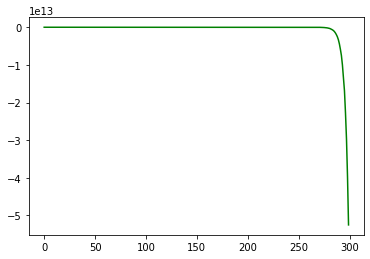

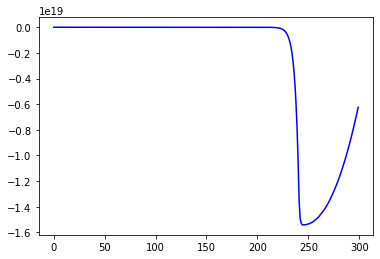

In [65]:
c.fit(300,1)

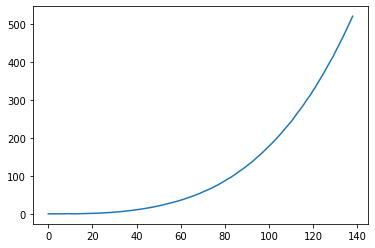

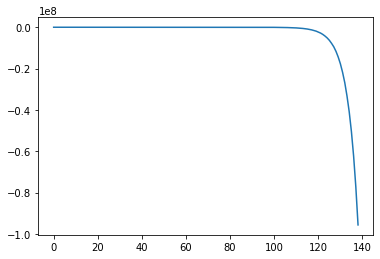

In [61]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

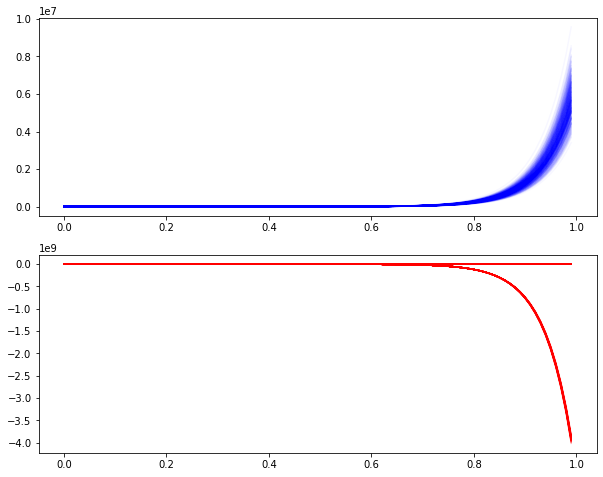

In [66]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sde_solver(X0=X1,dt=c.dt,  theta=c.theta_f,  beta=c.sigma, alfa=c.b_forward, N=c.number_time_steps)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )

t_, Xts_ = c.sde_solver(X0=X2, dt=c.dt,  theta=c.theta_b,  beta=c.sigma, alfa=bb, N=c.number_time_steps)
for i in range(n):
    
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03)


In [14]:
X22 = np.array(c.transport_batch( X1, True)).flatten()

In [15]:
X11 = np.array(c.transport_batch(X2, False)).flatten()

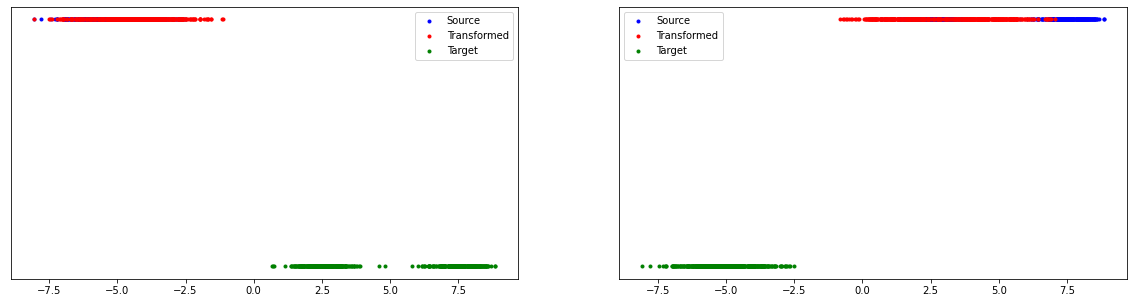

In [16]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [155]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

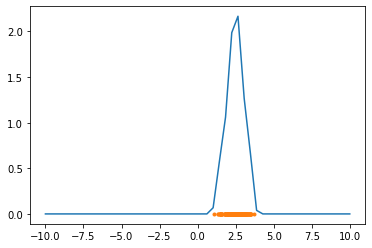

In [156]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [157]:
batch_terminal_empirical_b = next(c.data_stream(False))

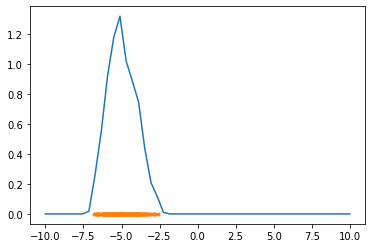

In [158]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")